<div class="alert alert-block alert-info" style='text-align:center'>
    Experiment begins here
</div>

# Notebook structure
1. [Packages used](#Import-packages)
2. [Some utilities](#Some-utilities)
3. [Dataset management](#Dataset)
4. [Modeling](#Modeling)
5. [Training pipeline](#Training-pipeline)
6. [Prediction time](#Prediction-time)

## Import packages

In [1]:
import sys
sys.path.append('../scripts')

In [2]:
from dataset import DataSet, DataModule
from model import Model
from utils import ramp_scheduler
from config import Config

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

import torch as th

import pytorch_lightning as pl
from pytorch_lightning import seed_everything, Trainer
from pytorch_lightning.callbacks import ModelCheckpoint, GPUStatsMonitor, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger

from sklearn.utils.class_weight import compute_class_weight

from tqdm.notebook import tqdm

## Some utilities

In [3]:
_ = seed_everything(Config.seed_value)

Global seed set to 2021


In [4]:
epochs = [x for x in range(100)]
lrs = [ramp_scheduler(epoch = x) for x in epochs]

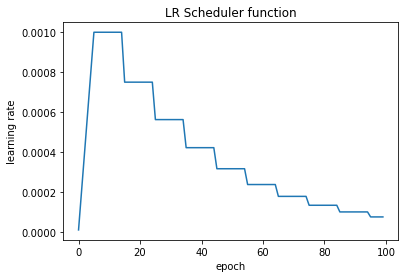

In [5]:
plt.title('LR Scheduler function')
plt.plot(epochs, lrs)
plt.xlabel('epoch')
plt.ylabel('learning rate')

plt.show()

<div class="alert alert-block alert-info" style='text-align:center' id="Dataset">
   Dataset
</div>

In [6]:
train_df = pd.read_csv(os.path.join(Config.data_dir, 'Train_10_folds.csv'))
train_df.head()

,ID,text,label,fold
0,13P0QT0,3sbaaaaaaaaaaaaaaaaaaaa lek ou le seim riahi o...,-1,7
1,SKCLXCJ,cha3eb fey9elkoum menghir ta7ayoul ou kressi,-1,9
2,V1TVXIJ,bereau degage nathef ya slim walahi ya7chiw fi...,-1,7
3,U0TTYY8,ak slouma,1,6
4,68DX797,entom titmanou lina a7na 3iid moubarik a7na ch...,-1,4


In [7]:
%%time
dm = DataModule(
    df=train_df,
    frac=1,
    train_batch_size= Config.train_batch_size,
    test_batch_size= Config.test_batch_size,
    test_size = .15
)

dm.setup()

[INFO] Training on 59500 samples belonging to 3 classes
[INFO] Validating on 10500 samples belonging to 3 classes
CPU times: user 410 ms, sys: 23.7 ms, total: 434 ms
Wall time: 6.61 s


## Model part

<div class="alert alert-block alert-info" style='text-align:center' id="Modeling">
   Modeling
</div>

### 1- Class weights computation

In [8]:
%%time

# compute class weights
class_w = compute_class_weight(
    class_weight='balanced', 
    classes=train_df.label.unique(), 
    y=train_df.label.values
)
class_w = th.from_numpy(class_w).float()
class_w

CPU times: user 12.8 ms, sys: 107 µs, total: 12.9 ms
Wall time: 12.1 ms


tensor([0.7965, 0.6102, 9.4620])

### 2- Model definition

In [9]:
%%time

# define model
model = Model(
    class_w=class_w
)

print(model.encoder)

DistilBertModel(
  (embeddings): Embeddings(
    (word_embeddings): Embedding(119547, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (layer): ModuleList(
      (0): TransformerBlock(
        (attention): MultiHeadSelfAttention(
          (dropout): Dropout(p=0.1, inplace=False)
          (q_lin): Linear(in_features=768, out_features=768, bias=True)
          (k_lin): Linear(in_features=768, out_features=768, bias=True)
          (v_lin): Linear(in_features=768, out_features=768, bias=True)
          (out_lin): Linear(in_features=768, out_features=768, bias=True)
        )
        (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (ffn): FFN(
          (dropout): Dropout(p=0.1, inplace=False)
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(

In [10]:
print(model.decoder)

Linear(in_features=768, out_features=3, bias=True)


## Training config/setup

<div class="alert alert-block alert-info" style='text-align:center' id="Training-pipeline">
   Training pipeline
</div>

### 1- Calbacks definition

In [11]:
model_ckpt = ModelCheckpoint(
    filename=os.path.join(
        Config.models_dir, f"arabizi-sentiments-{Config.base_model}"),
    monitor='val_acc',
    mode="max"
)
es = EarlyStopping(
    monitor='val_acc',
    patience=10,
    mode="max"
)
gpu_stats = GPUStatsMonitor(
    memory_utilization=True,
    gpu_utilization=True,
    intra_step_time=False,
    inter_step_time=False,
    fan_speed=True,
    temperature=True,
)

callbacks_list = [es, model_ckpt, gpu_stats]


### 2- Logger definition

In [12]:
tb_logger = TensorBoardLogger(
    save_dir=Config.logs_dir,
    name='zindi-arabizi',
    default_hp_metric=False
)

### 3- Trainer definition

In [13]:
trainer = Trainer(
    logger=tb_logger, 
    checkpoint_callback=True, 
    gpus=1,
    fast_dev_run=True,
    min_epochs=2,
    max_epochs=Config.num_epochs,
    precision=32,
    callbacks=callbacks_list
)

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
Running in fast_dev_run mode: will run a full train, val and test loop using 1 batch(es).


<div class="alert alert-block alert-info" style='text-align:center' id="Training-job">
   Training job
</div>

In [14]:
trainer.fit(
    model=model, 
    datamodule=dm
)


  | Name    | Type            | Params
--------------------------------------------
0 | encoder | DistilBertModel | 134 M 
1 | dropout | Dropout         | 0     
2 | pooler  | Linear          | 590 K 
3 | decoder | Linear          | 2.3 K 
--------------------------------------------
135 M     Trainable params
0         Non-trainable params
135 M     Total params
541.308   Total estimated model params size (MB)


Adjusting learning rate of group 0 to 3.0000e-09.
Adjusting learning rate of group 1 to 3.0000e-09.


Training: 0it [00:00, ?it/s]

ValueError: The `preds` should be probabilities, but values were detected outside of [0,1] range.

<div class="alert alert-block alert-info" style='text-align:center' id="Prediction-time">
   Prediction time
</div>